In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

from itertools import chain
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

from tqdm import tqdm

/Users/wibbn/.pyenv/versions/3.9.9/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/wibbn/.pyenv/versions/3.9.9/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/wibbn/.pyenv/versions/3.9.9/envs/ml/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
# В этой части лабораторной работы вам предстоит реализовать и обучить автокодировочную сеть на наборе данных MNIST.
# Сценарий выполнения кода:
# 1. Обучение автокодировщика.
# 2. Отображение проекции скрытого пространства на плоскость для визуальной оценки распределения данных в скрытом пространстве.
# 3. Интерполяция между несколькими точками в скрытом пространстве, декодирование промежуточных точек в исходное пространство
# и анимация результата.
# 4. Обучение простого классификатора на исходных данных (изображениях цифр) и на векторах в скрытом пространстве.
# 5. Проверка полученных классификаторов на тестовых данных.

In [2]:
class Encoder(nn.Module):
    # Класс кодивщика, необходимо реализовать.

    def __init__(self, inputs, latent_size):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.convs = nn.Sequential(
            nn.Conv2d(1, 4, 3, 1, 1),
            nn.ReLU()
        )

        self.linear = nn.Linear(4*28*28, latent_size)
        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        # print(x.shape)
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.linear(x)
        # print(x.shape)
        # ============
        return x


class Decoder(nn.Module):
    # Класс декодировщика, необходимо реализовать.

    def __init__(self, latent_size, outputs):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.linear = nn.Linear(latent_size, 4*28*28)
        self.upconvs = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, 3, 1, 1),
        )
        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        
        x = self.linear(x)
        x = x.view(x.size(0), -1, 28, 28)
        x = self.upconvs(x)
        # ============
        return x


class SimpleClassifier(nn.Module):
    # Класс простого классификатора.

    def __init__(self, inputs, outputs):
        super().__init__()
        self.fc = nn.Linear(inputs, outputs)

        self._inputs = inputs

    def forward(self, x):
        x = x.reshape(-1, self._inputs)
        x = self.fc(x)
        return x

class LatentSpaceDataset(Dataset):
    # Класс для преобразования изображений в вектора скрытого пространства.

    def __init__(self, orig_space_data_loader, encoder):
        super().__init__()
        self._data = list()
        for batch, target in orig_space_data_loader:
            latent_space_imgs = encoder(batch).detach()
            self._data.extend(zip(latent_space_imgs, target))

    def __len__(self):
        return len(self._data)

    def __getitem__(self, i):
        return self._data[i]

In [3]:
def train_ae(data_loader, encoder, decoder, epochs, lr):
    # Функция для обучения автокодировщика.
    # Принимает на вход загрузчик тренеровочных данных,
    # кодировщик, декодировщик, количество эпох для обучения и скорость обучения.

    encoder.train()
    decoder.train()

    print('Обучение автокодировщика..')

    loss_func = nn.MSELoss()  # функция потерь, нужно выбрать.
    optimizer = torch.optim.AdamW(chain(decoder.parameters(), encoder.parameters()))  # оптимизатор, нужно выбрать.
    loss_history = list()
    for epoch in tqdm(range(epochs)):
        for i, (batch, _) in enumerate(data_loader):
            # ВАШ КОД ЗДЕСЬ
            # batch = batch.reshape(batch.shape[0], -1)
            optimizer.zero_grad()
            forwd = encoder(batch)
            loss = loss_func(decoder(forwd), batch) # потери на пакете, нужно вычислить.
            loss.backward()
            optimizer.step()
            loss_history.append(loss.log().item())
            # ============
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    print('Готово!')

    encoder.eval()
    decoder.eval()

    plt.plot(loss_history)
    plt.show()


def train_classifier(data_loader, model, epochs, lr):
    # Функция для обучения классификатора.

    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    print('Обучение классификатора..')
    for epoch in range(epochs):
        for i, (batch, target) in enumerate(data_loader):
            optimizer.zero_grad()
            loss = loss_func(model(batch), target)
            loss.backward()
            optimizer.step()
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')
    print('Готово!')
    model.eval()


def test_classifier(data_loader, classifier):
    # Функция для тестирования классификатора.

    batch, target = next(iter(data_loader))
    print(accuracy_score(torch.argmax(classifier(batch), dim=1).detach().numpy(), target))


def lerp(v1, v2, t):
    # Функция для линейной интерполяции между двумя векторами.
    return v1 * (1 - t) + v2 * t


def get_frame(i, data):
    # Функция для анимации
    i = min(i, len(data) - 1)
    ax.clear()
    ax.imshow(data[i])

In [4]:
LATENT_SIZE = 64  # размерность скрытого пространства, можно варьировать.

BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 1e-4

ANIMATION_IMAGES = 5
ANIMATION_N_FRAMES = (ANIMATION_IMAGES - 1) * 20
ANIMATION_INTERVAL = 50

In [5]:
encoder = Encoder(28 * 28, LATENT_SIZE)
decoder = Decoder(LATENT_SIZE,  28 * 28)

print('Архитектура кодировщика: ')
# summary(encoder, [[28 * 28]])
print()
print('Архитектура декодировщика: ')
# summary(decoder, [[LATENT_SIZE]])

Архитектура кодировщика: 

Архитектура декодировщика: 


In [50]:
train_data = MNIST('data', train=True, download=True, transform=ToTensor())
test_data = MNIST('data', train=False, download=True, transform=ToTensor())
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

Обучение автокодировщика..


 10%|█         | 1/10 [00:05<00:47,  5.32s/it]

Эпоха 1 / 10. Потери на последнем пакете: 0.019910115748643875


 20%|██        | 2/10 [00:10<00:43,  5.39s/it]

Эпоха 2 / 10. Потери на последнем пакете: 0.012546943500638008


 30%|███       | 3/10 [00:16<00:37,  5.40s/it]

Эпоха 3 / 10. Потери на последнем пакете: 0.008829476311802864


 40%|████      | 4/10 [00:21<00:32,  5.36s/it]

Эпоха 4 / 10. Потери на последнем пакете: 0.009240085259079933


 50%|█████     | 5/10 [00:26<00:26,  5.33s/it]

Эпоха 5 / 10. Потери на последнем пакете: 0.00785311870276928


 60%|██████    | 6/10 [00:32<00:21,  5.31s/it]

Эпоха 6 / 10. Потери на последнем пакете: 0.007475225254893303


 70%|███████   | 7/10 [00:37<00:15,  5.31s/it]

Эпоха 7 / 10. Потери на последнем пакете: 0.007680687587708235


 80%|████████  | 8/10 [00:42<00:10,  5.36s/it]

Эпоха 8 / 10. Потери на последнем пакете: 0.007197199389338493


 90%|█████████ | 9/10 [00:48<00:05,  5.38s/it]

Эпоха 9 / 10. Потери на последнем пакете: 0.0073774573393166065


100%|██████████| 10/10 [00:53<00:00,  5.36s/it]

Эпоха 10 / 10. Потери на последнем пакете: 0.0063787708058953285
Готово!


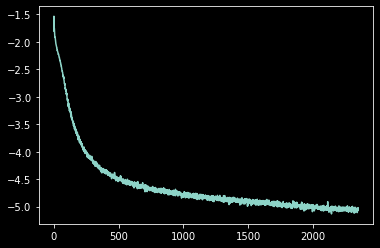

In [51]:
train_ae(train_data_loader, encoder, decoder, EPOCHS, LEARNING_RATE)

Проецирование скрытого пространства на плоскость..


/Users/wibbn/.pyenv/versions/3.9.9/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/wibbn/.pyenv/versions/3.9.9/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Готово!


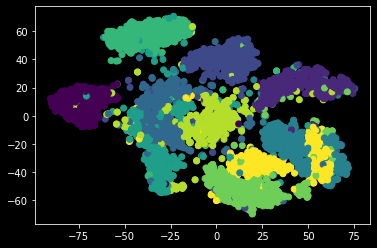

In [52]:
test_imgs = list()
for batch, target in train_data_loader:
    test_imgs.extend(zip(batch, target))
    if len(test_imgs) > 5000:
        break
imgs_list, targets = zip(*test_imgs)
imgs = torch.stack(imgs_list)

print('Проецирование скрытого пространства на плоскость..')
tsne = TSNE()
latent_imgs_emb = [encoder(img.unsqueeze(0))[0].detach().numpy() for img in imgs]
latent_imgs_emb = tsne.fit_transform(np.array(latent_imgs_emb))
x, y = zip(*latent_imgs_emb)
plt.scatter(x, y, c=targets)
print('Готово!')
plt.show()

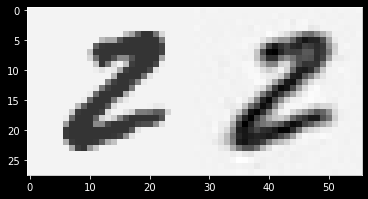

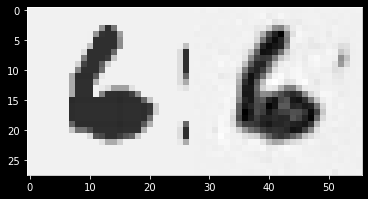

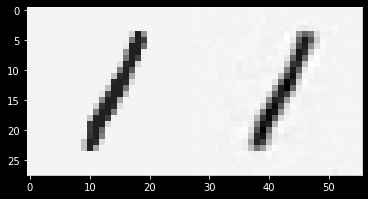

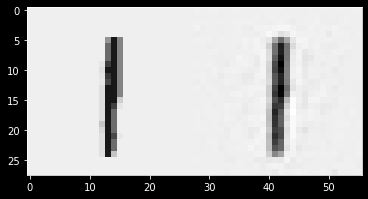

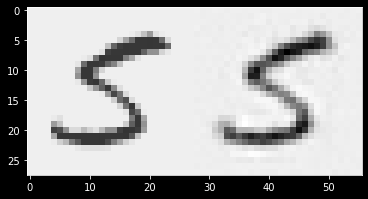

In [53]:
latent_imgs = encoder(imgs)
restored_imgs = decoder(latent_imgs)

restored_imgs = restored_imgs.reshape(-1, 1, 28, 28)

# print()
# print(imgs[1][0].shape)
# print()
# # print(restored_imgs[1][0].detach())
# print(restored_imgs.shape)
# print(torch.reshape(restored_imgs, (-1, 1, 28, 28)).shape)
# print(torch.reshape(restored_imgs, (-1, 1, 28, 28))[1][0].detach().shape)
# print(torch.reshape(restored_imgs[1].detach(), (28, 28)).shape)
# print()

for i in range(5):
    orig_restored = torch.hstack((imgs[i][0], restored_imgs[i][0].detach()))
    plt.imshow(orig_restored.numpy(), cmap='Greys')
    plt.show()

In [54]:
x_classifier = SimpleClassifier(28 * 28, 10)
train_classifier(train_data_loader, x_classifier, epochs=10, lr=1e-4)

latent_space_train_data_loader = DataLoader(LatentSpaceDataset(train_data_loader, encoder), batch_size=BATCH_SIZE, shuffle=True)

z_classifier = SimpleClassifier(LATENT_SIZE, 10)
train_classifier(latent_space_train_data_loader, z_classifier, epochs=10, lr=1e-4)

orig_test_data_loader = DataLoader(test_data, batch_size=1024, shuffle=True)
latent_test_data_loader = DataLoader(LatentSpaceDataset(orig_test_data_loader, encoder), batch_size=1024, shuffle=True)

test_classifier(orig_test_data_loader, x_classifier)
test_classifier(latent_test_data_loader, z_classifier)

Обучение классификатора..
Эпоха 1 / 10. Потери на последнем пакете: 1.5339723825454712
Эпоха 2 / 10. Потери на последнем пакете: 1.10910165309906
Эпоха 3 / 10. Потери на последнем пакете: 0.8813137412071228
Эпоха 4 / 10. Потери на последнем пакете: 0.7706953883171082
Эпоха 5 / 10. Потери на последнем пакете: 0.7408669590950012
Эпоха 6 / 10. Потери на последнем пакете: 0.6204590797424316
Эпоха 7 / 10. Потери на последнем пакете: 0.5721753239631653
Эпоха 8 / 10. Потери на последнем пакете: 0.4083259105682373
Эпоха 9 / 10. Потери на последнем пакете: 0.4159657657146454
Эпоха 10 / 10. Потери на последнем пакете: 0.43943658471107483
Готово!
Обучение классификатора..
Эпоха 1 / 10. Потери на последнем пакете: 2.1977858543395996
Эпоха 2 / 10. Потери на последнем пакете: 2.028667449951172
Эпоха 3 / 10. Потери на последнем пакете: 1.7882933616638184
Эпоха 4 / 10. Потери на последнем пакете: 1.7242177724838257
Эпоха 5 / 10. Потери на последнем пакете: 1.534070372581482
Эпоха 6 / 10. Потери на пос